# Proyecto: Naive Bayes con Estimación KDE para Mantenimiento Predictivo

---

## Objetivo

Diseñar e implementar un clasificador propio basado en **Naive Bayes**, en el que la verosimilitud $P(x_i \mid y)$ se estime utilizando técnicas de **Kernel Density Estimation (KDE)** en lugar de asumir una distribución normal.

Se utilizará el **AI4I 2020 Predictive Maintenance Dataset**, con la variable objetivo `Machine failure`. El proyecto buscará responder empíricamente si reemplazar la suposición gaussiana clásica por KDE resulta en una mejora real en desempeño.

---

## Fundamento teórico

### Naive Bayes

El clasificador **Naive Bayes** es un modelo probabilístico basado en el **teorema de Bayes** con una fuerte asunción de independencia entre las variables dado el valor de la clase. Su objetivo es calcular la probabilidad posterior de una clase $y$ dado un vector de atributos $\mathbf{x} = (x_1, x_2, \dots, x_n)$:

$$
P(y \mid \mathbf{x}) = \frac{P(y) \cdot P(\mathbf{x} \mid y)}{P(\mathbf{x})}
$$

Dado que $P(\mathbf{x})$ es constante para todas las clases en un problema de clasificación, la predicción se basa en:

$$
\hat{y} = \arg\max_y \; P(y) \prod_{i=1}^{n} P(x_i \mid y)
$$

La clave está en estimar adecuadamente las distribuciones de las verosimilitudes $P(x_i \mid y)$.


### Gaussian Naive Bayes

En el enfoque **Gaussian Naive Bayes (GNB)**, se hace la **asunción paramétrica** de que cada variable numérica sigue una distribución **normal univariada** dentro de cada clase. Es decir:

$$
P(x_i \mid y) = \mathcal{N}(x_i \mid \mu_{iy}, \sigma^2_{iy}) = \frac{1}{\sqrt{2\pi \sigma^2_{iy}}} \exp\left( -\frac{(x_i - \mu_{iy})^2}{2\sigma^2_{iy}} \right)
$$

Donde $\mu_{iy}$ y $\sigma^2_{iy}$ se estiman directamente desde los datos de entrenamiento.

Este supuesto simplifica el modelo, pero puede ser problemático si los datos no siguen una distribución gaussiana, por ejemplo, si son **multimodales, sesgados o tienen colas pesadas**.


### KDE como alternativa para estimar la verosimilitud

Una alternativa interesante a asumir una distribución normal es usar un enfoque **no paramétrico** para estimar la densidad de probabilidad: la **Kernel Density Estimation (KDE)**.

En este método, la verosimilitud $P(x_i \mid y)$ se estima directamente a partir de los datos de entrenamiento, sumando pequeñas funciones kernel centradas en cada observación. La forma general es:

$$
\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
$$

Donde:
- $K$ es la función kernel (por ejemplo, gaussiana, triangular, rectangular),
- $h$ es el parámetro de suavizado o **bandwidth**,
- $x_i$ son las observaciones de la clase $y$.

Este enfoque permite capturar formas de distribución **arbitrarias** y potencialmente más realistas que una gaussiana simple, lo cual podría mejorar la clasificación en contextos donde la suposición de normalidad no se cumple.

En este proyecto, exploraremos esta idea usando tres variantes de KDE y comparándolas contra Gaussian Naive Bayes, evaluando cuál ofrece un mejor desempeño en el contexto de mantenimiento predictivo.


---

## Dataset

- **Nombre:** AI4I 2020 Predictive Maintenance Dataset  
- **Fuente:** UCI / Kaggle  
- **Target:** `Machine failure` (binaria)  
- **Características:** Datos de sensores, condiciones operativas, tiempos de uso  
- **Consideración crítica:** Dataset **desbalanceado**, con una minoría de fallas reales.  
- Se recomienda realizar una revisión de la literatura sobre cómo se ha abordado el desbalance en este dataset.

---

## Metodología

### 1. Implementación de clasificador Naive Bayes personalizado

- Se implementará un clasificador Naive Bayes desde cero.
- Para cada clase $y$, se estima la verosimilitud de cada variable continua $x_i$ como $P(x_i \mid y)$ usando métodos no paramétricos de KDE.
- Se comparará el rendimiento del modelo con un `GaussianNB` de `sklearn` como baseline.



### 2. Evaluación de tres métodos de KDE

Cada grupo deberá comparar los siguientes tres métodos de estimación de densidad para calcular la verosimilitud $P(x_i \mid y)$.



#### a. KDE clásico con kernel gaussiano + optimización de `bandwidth`

- Se utiliza un kernel gaussiano para estimar la densidad:
  
  $$
  \hat{f}(x) = \frac{1}{n h \sqrt{2\pi}} \sum_{i=1}^{n} \exp\left( -\frac{(x - x_i)^2}{2h^2} \right)
  $$

- El parámetro `bandwidth` $h$ controla la suavidad de la estimación.
- Para seleccionar un valor apropiado de $h$, se debe usar un método de optimización como **Grid Search** o preferiblemente **optimización bayesiana**, evaluando el rendimiento del modelo en términos de **AUC ROC** mediante validación cruzada (al menos 5 folds).



#### b. KDE tipo Parzen (ventanas simples)

- En este enfoque, se reemplaza el kernel gaussiano por una ventana de forma simple, como rectangular o triangular.

  - **Ventana rectangular (tophat):**
    $$
    K(u) = \frac{1}{2} \cdot \mathbb{I}(|u| \leq 1)
    $$

  - **Ventana triangular:**
    $$
    K(u) = (1 - |u|) \cdot \mathbb{I}(|u| \leq 1)
    $$

- El modelo general de densidad estimada sigue siendo:

  $$
  \hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
  $$

- El ancho de ventana $h$ debe definirse manualmente y mantenerse fijo.
- Puede implementarse directamente o usando `sklearn.neighbors.KernelDensity` con `kernel='tophat'` o `'linear'`.


#### c. KDE con regla de Silverman

- Se utiliza un kernel gaussiano, pero el `bandwidth` se calcula automáticamente con la **regla de Silverman**:

  $$
  h = 1.06 \cdot \hat{\sigma} \cdot n^{-1/5}
  $$

- La estimación de la densidad sigue la misma forma que el KDE gaussiano clásico:

  $$
  \hat{f}(x) = \frac{1}{n h \sqrt{2\pi}} \sum_{i=1}^{n} \exp\left( -\frac{(x - x_i)^2}{2h^2} \right)
  $$

- Este método no requiere ajuste de hiperparámetros.
- Se puede implementar fácilmente con `scipy.stats.gaussian_kde`.



---

## Instrucciones de evaluación

- **Métrica principal:** Área bajo la curva ROC (AUC ROC)
- **Procedimiento de validación:** Validación cruzada estratificada de 5 folds
  - Usar el mismo esquema de partición para todos los métodos para asegurar comparabilidad.
  - Calcular el AUC promedio y su desviación estándar para cada modelo.
  - Registrar los tiempos de procesamiento

- **Modelos a comparar:**
  - Naive Bayes clásico (`GaussianNB`. Pueden usar el de Scikit Learn)
  - Naive Bayes con KDE:
    - KDE con kernel gaussiano y bandwidth ajustado por optimización
    - KDE con ventana tipo Parzen
    - KDE con regla de Silverman

- **Objetivo del análisis:**
  - Determinar si vale la pena reemplazar la suposición de normalidad por KDE en este problema.
  - Comparar las tres variantes de KDE y explicar cuál se comporta mejor y bajo qué condiciones (tamaño del bandwidth, forma de la distribución, impacto del desbalance, etc.).
  - Identificar si el ajuste del bandwidth influye significativamente en el desempeño del modelo correspondiente.
  - Comparar el tiempo de computación de cada método y analizar su impacto en la viabilidad práctica.

---

## Consideraciones adicionales

- **Desbalanceo:**
  - Investigar y aplicar estrategias adecuadas para el tratamiento del desbalance en el dataset (por ejemplo: submuestreo, sobreponderación, uso de métricas balanceadas).
  - Buscar artículos académicos (Google Scholar, Scopus, etc.) que hayan trabajado con el AI4I 2020 dataset y reportado técnicas o resultados relevantes para manejar el desbalanceo.
  
- **Preprocesamiento de variables:**
  - Analizar y justificar la eliminación o transformación de columnas irrelevantes, constantes o ruidosas.
  - Evaluar si es necesario aplicar técnicas de **normalización** o **estandarización** sobre las variables numéricas.
    - Si se aplican, explicar qué método se usó (e.g., `StandardScaler`, `MinMaxScaler`) y por qué.
    - Si no se aplican, justificar por qué no se consideran necesarias dadas las características del modelo y del dataset.

- **Visualización (opcional pero recomendada):**
  - Graficar las curvas de densidad estimadas para algunas variables por clase, con diferentes métodos de KDE.
  - Mostrar gráficamente el efecto del parámetro `bandwidth` en la forma de la distribución.

---

## Entregables

- **Código fuente documentado:** en formato Jupyter Notebook o scripts Python bien estructurados.
- **Repositorio en GitHub:**  
  - El proyecto completo debe entregarse en un repositorio público o privado (según indicaciones), incluyendo:
    - Código fuente
    - Archivo README con instrucciones de ejecución
    - Presentación en formato `.pptx` o `.pdf`
    - Cualquier recurso adicional necesario para reproducir los experimentos

- **Presentación oral (15 + 5 minutos):**
  - 15 minutos de exposición + 5 minutos de preguntas por parte del docente o compañeros.
  - Debe incluir:
    - Descripción clara de los métodos comparados
    - Justificación del preprocesamiento realizado
    - Visualizaciones de las distribuciones de verosimilitud (KDE) y curvas ROC
    - Reporte de AUC promedio, luego de una validación cruzada de al menos 5 folds, de cada modelo analizado
    - Análisis crítico: ¿usar KDE mejora la clasificación frente al modelo gaussiano tradicional? ¿bajo qué condiciones?
    - Comparación de tiempos de computación entre los métodos.

---

## Recomendaciones

- Leer artículos recientes que hayan trabajado con el **AI4I 2020 Predictive Maintenance Dataset**, en especial aquellos que discuten estrategias para manejar el **desbalance de clases**. Usar fuentes confiables como Google Scholar o Scopus.

- Apoyarse en la **teoría revisada en clase** y en el **material del curso disponible en el repositorio oficial**. Revisar los notebooks de ejemplos, apuntes, y recursos adicionales proporcionados por el docente.

- Se recomienda fuertemente el uso de herramientas de inteligencia artificial como **ChatGPT** o **GitHub Copilot** para:
  - Aclarar dudas conceptuales.
  - Obtener sugerencias de código.
  - Redactar fragmentos documentados.
  - Mejorar el entendimiento de errores o ajustes técnicos.

> El uso de estas herramientas debe ser **ético, transparente y reflexivo**. No se trata de copiar código sin entenderlo, sino de apoyarse en IA como una forma de acelerar el trabajo, validar ideas y fomentar buenas prácticas.

---

## Referencias

- Los artículos académicos utilizados como referencia deben ser mencionados al final de la presentación en formato **IEEE**.

---

## Fecha de entrega

- **Límite de entrega:** domingo **22 de julio**, hasta las **23:59 (hora local)**.
- El proyecto debe entregarse mediante un **repositorio en GitHub**, incluyendo:
  - Código funcional y documentado
  - Informe en formato `.pptx` o `.pdf`
  - Instrucciones para reproducir los resultados

---

## Rúbrica de Evaluación (100 puntos)

### Código y reporte técnico — 50 puntos

| Criterio                                                                 | Puntos |
|--------------------------------------------------------------------------|--------|
| Implementación funcional de los tres métodos de KDE                      | 15     |
| Optimización de `bandwidth` (KDE gaussiano) usando validación cruzada con AUC como métrica | 10     |
| Comparación cuantitativa con GaussianNB usando AUC en validación cruzada (5 folds) | 5      |
| Documentación clara en el notebook o scripts (comentarios, celdas explicativas, encabezados) | 10     |
| Visualización y análisis de resultados (curvas de densidad, curvas ROC, resumen de AUC) | 5      |
| Justificación y evidencia sobre el manejo del desbalance y preprocesamiento aplicado | 5      |


### Presentación oral — 50 puntos

| Criterio                                                                 | Puntos |
|--------------------------------------------------------------------------|--------|
| Explicación clara del enfoque Naive Bayes y motivación de usar KDE       | 10     |
| Comparación detallada entre métodos de KDE y GaussianNB                  | 10     |
| Justificación clara de decisiones de diseño y preprocesamiento           | 10     |
| Análisis crítico de resultados                                          | 10     |
| Claridad, manejo del tiempo, calidad visual de la presentación (diapositivas) | 10     |

---

**Total: 100 puntos**

## Paso 1: Carga del Dataset

En este paso se importan las librerías fundamentales y se realiza la carga inicial del dataset AI4I 2020 Predictive Maintenance. Se visualizan las primeras filas para inspeccionar el formato de los datos.

In [1]:
import pandas as pd
import numpy as np

# Cargar el dataset (ajustar ruta si es necesario)
df = pd.read_csv("./ai4i_2020/ai4i2020.csv")

# Mostrar las primeras 10 filas para inspección inicial
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


## Paso 2: Limpieza de nombres de columnas y Análisis Exploratorio de Datos (EDA)

En este paso se realiza la limpieza de los nombres de las columnas para evitar errores por espacios, y se lleva a cabo un análisis exploratorio básico del dataset:
- Limpieza de nombres de columnas
- Resumen de tipos de datos y valores nulos
- Estadísticas descriptivas
- Análisis de la variable objetivo (`Machine failure`)

In [4]:
# --- 2.1 LIMPIEZA DE NOMBRES DE COLUMNAS ---
# Función para limpiar nombres: reemplaza múltiples espacios por uno y elimina espacios al inicio/final
def limpiar_nombre_columna(col):
    col = ' '.join(col.split())
    return col.strip()

# Aplicar la limpieza a todos los nombres de columna
df.columns = [limpiar_nombre_columna(col) for col in df.columns]

print("--- Nombres de columnas después de la limpieza ---")
print(df.columns.tolist())

# --- 2.2 ANÁLISIS DE TIPOS DE DATOS Y ESTADÍSTICAS ---
print("\n--- 2.2.1 Información General del DataFrame ---")
df.info()

print("\n--- 2.2.2 Estadísticas Descriptivas de Variables Numéricas ---")
print(df.describe())

# --- 2.3 ANÁLISIS DE LA VARIABLE OBJETIVO ---
print(f"\n--- 2.3.1 Conteo de la Variable Objetivo ('Machine failure') ---")
conteo_fallos = df['Machine failure'].value_counts()
print(conteo_fallos)

porcentaje_fallos = (conteo_fallos.get(1, 0) / df.shape[0]) * 100
print(f"\nPorcentaje de Fallo de Máquina (Clase 1): {porcentaje_fallos:.2f}%")
print("Este bajo porcentaje confirma un problema de desbalance de clases.")

--- Nombres de columnas después de la limpieza ---
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

--- 2.2.1 Información General del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9  

## Paso 3: Preprocesamiento de Datos y Escalado

En este paso se realiza el preprocesamiento esencial para preparar los datos antes de entrenar los modelos:
- Eliminación de columnas irrelevantes
- Codificación de variables categóricas
- Identificación y escalado de variables numéricas
- División en conjuntos de entrenamiento y prueba (70/30, estratificado)


In [5]:
# Importar librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Volver a cargar el dataframe original y limpiar nombres
# (Esto asegura que el preprocesamiento parte de datos limpios y sin modificaciones previas)
df = pd.read_csv("./ai4i_2020/ai4i2020.csv")
def limpiar_nombre_columna(col):
    col = ' '.join(col.split())
    return col.strip()
df.columns = [limpiar_nombre_columna(col) for col in df.columns]
NOMBRE_OBJETIVO = 'Machine failure'

# 3.1 Columnas a eliminar
columnas_a_eliminar = [
    'UDI', 
    'Product ID', 
    # Eliminar causas binarias de fallo
    'TWF', 'HDF', 'PWF', 'OSF', 'RNF'
]
df = df.drop(columns=columnas_a_eliminar)
print(f"Columnas eliminadas: {columnas_a_eliminar}")

# 3.2 Separar X (predictoras) e y (objetivo)
X = df.drop(columns=[NOMBRE_OBJETIVO])
y = df[NOMBRE_OBJETIVO]

# 3.3 Codificación de Variable Categórica ('Type')
X = pd.get_dummies(X, columns=['Type'], drop_first=True) 
print(f"Columnas finales de X: {X.columns.tolist()}")

# 3.4 Identificar y Escalar columnas numéricas
columnas_numericas = X.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X[columnas_numericas] = scaler.fit_transform(X[columnas_numericas])

# 3.5 División en conjuntos de entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\n--- Resumen de la División ---")
print(f"Tamaño de Entrenamiento (X_train): {X_train.shape}")
print(f"Tamaño de Prueba (X_test): {X_test.shape}")

Columnas eliminadas: ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Columnas finales de X: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_L', 'Type_M']

--- Resumen de la División ---
Tamaño de Entrenamiento (X_train): (7000, 7)
Tamaño de Prueba (X_test): (3000, 7)


## Paso 4: Establecer la Línea Base (IA 1 - GaussianNB)

En este paso se implementa el modelo Gaussian Naive Bayes estándar de Scikit-learn como línea base. Este resultado servirá como referencia para comparar los modelos Naive Bayes con KDE en los siguientes pasos.

In [9]:
# 4.1 Importar el modelo y la métrica de evaluación
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

# 4.2 Instanciar y Entrenar el modelo
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# 4.3 Predecir las probabilidades en el conjunto de prueba
y_pred_proba_gnb = gnb_model.predict_proba(X_test)[:, 1]

# 4.4 Evaluar el modelo con la métrica AUC ROC
auc_roc_gnb = roc_auc_score(y_test, y_pred_proba_gnb)

print("--- Evaluación de la Línea Base (Gaussian Naive Bayes) ---")
print(f"AUC ROC del Baseline (GaussianNB): {auc_roc_gnb:.4f}")

# Guardamos el resultado del baseline para compararlo en pasos futuros
resultados = {'GaussianNB_Baseline': auc_roc_gnb}

--- Evaluación de la Línea Base (Gaussian Naive Bayes) ---
AUC ROC del Baseline (GaussianNB): 0.8626


## Paso 5: Implementación del Clasificador Naive Bayes Personalizado (KDE)

En este paso se implementa un clasificador Naive Bayes propio, que utiliza estimación de densidad por kernel (KDE) para modelar la verosimilitud de cada variable. Se emplea el logaritmo de las probabilidades para evitar problemas de underflow y se aplica suavizado (clipping) para evitar valores extremos en las probabilidades.

In [10]:
# =================================================================
# PASO 5: IMPLEMENTACIÓN DEL CLASIFICADOR NAIVE BAYES PERSONALIZADO
# (INCLUYE CORRECCIÓN DE SUAVIZADO/CLIPPING PARA EVITAR ERRORES NaN EN AUC ROC)
# =================================================================

import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin

# Definimos el valor de suavizado para el clipping
SMOOTHING_CLIP = 1e-10

class CustomNaiveBayesKDE(BaseEstimator, ClassifierMixin):
    
    def __init__(self, kernel='gaussian', bandwidth=1.0):
        # Almacena el tipo de kernel y el bandwidth (h)
        self.kernel = kernel
        self.bandwidth = bandwidth
        
        # Inicializa las variables que se almacenarán durante el entrenamiento
        self.classes_ = None
        self.class_log_prior_ = None
        self.feature_estimators_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        
        # Inicializar estructuras para almacenar las probabilidades a priori y los estimadores de densidad
        self.class_log_prior_ = {}
        self.feature_estimators_ = {}
        
        # 1. Calcular Probabilidad a Priori (P(y))
        for c in self.classes_:
            # Obtener índices de las muestras que pertenecen a la clase actual
            X_c = X[y == c]
            
            # Calcular log(P(y))
            self.class_log_prior_[c] = np.log(X_c.shape[0] / X.shape[0])
            
            # 2. Entrenar KDE para cada característica (P(x_i | y))
            self.feature_estimators_[c] = {}
            for i in range(n_features):
                # Extraer la característica i para la clase c
                feature_data = X_c.iloc[:, i].values.reshape(-1, 1)
                
                # Instanciar y entrenar el KDE con el kernel y bandwidth definidos
                kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth)
                kde.fit(feature_data)
                self.feature_estimators_[c][i] = kde

        return self

    def predict_proba(self, X):
        n_samples = X.shape[0]
        # Inicializar matriz de log-probabilidades (una fila por muestra, una columna por clase)
        log_prob_matrix = np.zeros((n_samples, len(self.classes_)))
        
        # Calcular log(P(y | x)) para cada clase
        for idx, c in enumerate(self.classes_):
            # Sumar el log-prior (log(P(y)))
            log_prob_matrix[:, idx] = self.class_log_prior_[c]
            
            # Sumar las log-verosimilitudes (log(P(x_i | y))) para cada característica
            n_features = X.shape[1]
            for i in range(n_features):
                feature_data = X.iloc[:, i].values.reshape(-1, 1)
                
                # Obtener log-verosimilitud del KDE
                log_likelihoods = self.feature_estimators_[c][i].score_samples(feature_data)
                
                # log(P(y | x)) = log(P(y)) + SUM(log(P(x_i | y)))
                log_prob_matrix[:, idx] += log_likelihoods

        # 3. Convertir log-probabilidades a probabilidades normales
        max_log_prob = np.max(log_prob_matrix, axis=1, keepdims=True)
        exp_prob = np.exp(log_prob_matrix - max_log_prob)
        
        # Normalizar para que las probabilidades sumen 1
        prob_matrix = exp_prob / np.sum(exp_prob, axis=1, keepdims=True)
        
        # 🚀 APLICAR CLIPPING: Asegurar que las probabilidades no sean 0 o 1 exacto
        prob_matrix = np.clip(prob_matrix, SMOOTHING_CLIP, 1 - SMOOTHING_CLIP)
        
        return prob_matrix

    def predict(self, X):
        # La predicción es simplemente la clase con la probabilidad más alta
        probabilities = self.predict_proba(X)
        return self.classes_[np.argmax(probabilities, axis=1)]

print("Clase CustomNaiveBayesKDE definida exitosamente con suavizado (clipping).")

Clase CustomNaiveBayesKDE definida exitosamente con suavizado (clipping).


## Paso 6: KDE con Regla de Silverman (Método 2.c)

En este paso se implementa y evalúa un clasificador Naive Bayes personalizado que utiliza la estimación de densidad por kernel (KDE) con la **regla de Silverman** para el cálculo automático del bandwidth, usando `scipy.stats.gaussian_kde`.

In [11]:
# =================================================================
# PASO 6: IMPLEMENTACIÓN Y EVALUACIÓN DE KDE CON REGLA DE SILVERMAN
# =================================================================

from scipy.stats import gaussian_kde
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin

# Asume que CustomNaiveBayesKDE ya está definida del Paso 5

class CustomNaiveBayesKDE_Silverman(CustomNaiveBayesKDE):
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        self.class_log_prior_ = {}
        self.feature_estimators_ = {}
        for c in self.classes_:
            X_c = X[y == c]
            self.class_log_prior_[c] = np.log(X_c.shape[0] / X.shape[0])
            self.feature_estimators_[c] = {}
            for i in range(n_features):
                feature_data = X_c.iloc[:, i].values.astype(np.float64)
                kde = gaussian_kde(feature_data)
                self.feature_estimators_[c][i] = kde
        return self

    def predict_proba(self, X):
        n_samples = X.shape[0]
        log_prob_matrix = np.zeros((n_samples, len(self.classes_)))
        for idx, c in enumerate(self.classes_):
            log_prob_matrix[:, idx] = self.class_log_prior_[c]
            n_features = X.shape[1]
            for i in range(n_features):
                feature_data = X.iloc[:, i].values.astype(np.float64)
                log_likelihoods = self.feature_estimators_[c][i].logpdf(feature_data)
                log_prob_matrix[:, idx] += log_likelihoods
        max_log_prob = np.max(log_prob_matrix, axis=1, keepdims=True)
        exp_prob = np.exp(log_prob_matrix - max_log_prob)
        prob_matrix = exp_prob / np.sum(exp_prob, axis=1, keepdims=True)
        return prob_matrix

# 6.3 Evaluación del Modelo con Regla de Silverman
modelo_silverman = CustomNaiveBayesKDE_Silverman()
modelo_silverman.fit(X_train, y_train)
y_pred_proba_silverman = modelo_silverman.predict_proba(X_test)[:, 1]
auc_roc_silverman = roc_auc_score(y_test, y_pred_proba_silverman)

print("--- Evaluación de KDE con Regla de Silverman ---")
print(f"AUC ROC (KDE Silverman): {auc_roc_silverman:.4f}")

# Guardar el resultado para comparación
resultados['KDE_Silverman'] = auc_roc_silverman
print("\nResultados actuales para comparación:")
print(pd.Series(resultados))

--- Evaluación de KDE con Regla de Silverman ---
AUC ROC (KDE Silverman): 0.9134

Resultados actuales para comparación:
GaussianNB_Baseline    0.862633
KDE_Silverman          0.913405
dtype: float64


## Paso 7: KDE Tipo Parzen (Ventanas Simples)

En este paso se implementan y evalúan los modelos Naive Bayes con KDE tipo Parzen usando kernels simples (rectangular/tophat y triangular/linear) y un bandwidth fijo, como indica la metodología.

In [12]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Definimos un bandwidth fijo para el método Parzen (este valor es arbitrario para empezar)
H_PARZEN_FIJO = 0.5 
print(f"Usando bandwidth fijo (h) = {H_PARZEN_FIJO} para métodos Parzen.")

# --- 7.1 Modelo KDE Parzen con Kernel Rectangular (Tophat) ---
print("\n--- 7.1 Evaluación KDE Parzen (Tophat) ---")
modelo_parzen_tophat = CustomNaiveBayesKDE(kernel='tophat', bandwidth=H_PARZEN_FIJO)
modelo_parzen_tophat.fit(X_train, y_train)

y_pred_proba_tophat = modelo_parzen_tophat.predict_proba(X_test)[:, 1]
auc_roc_tophat = roc_auc_score(y_test, y_pred_proba_tophat)

print(f"AUC ROC (KDE Tophat, h={H_PARZEN_FIJO}): {auc_roc_tophat:.4f}")
resultados['KDE_Parzen_Tophat'] = auc_roc_tophat

# --- 7.2 Modelo KDE Parzen con Kernel Triangular (Linear) ---
print("\n--- 7.2 Evaluación KDE Parzen (Linear) ---")
modelo_parzen_linear = CustomNaiveBayesKDE(kernel='linear', bandwidth=H_PARZEN_FIJO)
modelo_parzen_linear.fit(X_train, y_train)

y_pred_proba_linear = modelo_parzen_linear.predict_proba(X_test)[:, 1]
auc_roc_linear = roc_auc_score(y_test, y_pred_proba_linear)

print(f"AUC ROC (KDE Linear, h={H_PARZEN_FIJO}): {auc_roc_linear:.4f}")
resultados['KDE_Parzen_Linear'] = auc_roc_linear

# --- 7.3 Resumen de Resultados ---
print("\n--- Resumen de Resultados Acumulados ---")
print(pd.Series(resultados).sort_values(ascending=False))

Usando bandwidth fijo (h) = 0.5 para métodos Parzen.

--- 7.1 Evaluación KDE Parzen (Tophat) ---
AUC ROC (KDE Tophat, h=0.5): 0.9115

--- 7.2 Evaluación KDE Parzen (Linear) ---
AUC ROC (KDE Linear, h=0.5): 0.9156

--- Resumen de Resultados Acumulados ---
KDE_Parzen_Linear      0.915594
KDE_Silverman          0.913405
KDE_Parzen_Tophat      0.911450
GaussianNB_Baseline    0.862633
dtype: float64


## Paso 8: KDE Gaussiano con Optimización Bayesiana (GridSearchCV)

En este paso se implementa el KDE Gaussiano (Método 2.a) optimizando el parámetro de bandwidth usando GridSearchCV para maximizar el AUC ROC mediante validación cruzada.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

print("--- 8.1 Optimizando el Bandwidth (h) para KDE Gaussiano ---")

# 8.2 Definir el rango de valores de 'h' (bandwidth) a probar
param_grid = {
    'bandwidth': np.logspace(-1, 0.3, 15) # Rango de h desde ~0.1 hasta ~2.0
}

# 8.3 Configurar GridSearchCV para buscar el mejor 'h'
nb_kde_gauss = CustomNaiveBayesKDE(kernel='gaussian')

grid_search = GridSearchCV(
    nb_kde_gauss,
    param_grid,
    scoring='roc_auc',
    cv=5, 
    verbose=1,
    n_jobs=-1
)

# 8.4 Entrenar y encontrar el h óptimo
grid_search.fit(X_train, y_train)

# 8.5 Obtener el mejor resultado y evaluarlo en X_test
best_h = grid_search.best_params_['bandwidth']
best_model_opt = grid_search.best_estimator_

y_pred_proba_opt = best_model_opt.predict_proba(X_test)[:, 1]
auc_roc_opt = roc_auc_score(y_test, y_pred_proba_opt)

print(f"\n--- 8.6 Evaluación Final ---")
print(f"El mejor bandwidth (h) encontrado es: {best_h:.4f}")
print(f"AUC ROC (KDE Gaussiano Optimizado): {auc_roc_opt:.4f}")

# Almacenar el resultado final
resultados['KDE_Gaussiano_Optimizado'] = auc_roc_opt

--- 8.1 Optimizando el Bandwidth (h) para KDE Gaussiano ---
Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\juanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



--- 8.6 Evaluación Final ---
El mejor bandwidth (h) encontrado es: 0.1000
AUC ROC (KDE Gaussiano Optimizado): 0.9132


## Paso 9: Imprimir Resultados Finales

En este paso se imprime un resumen final de los resultados obtenidos por cada modelo Naive Bayes implementado, ordenados por su desempeño (AUC ROC).

In [14]:
print("\n--- PASO 9: RESUMEN FINAL DE LA METODOLOGÍA ---")
resultados_df = pd.Series(resultados).sort_values(ascending=False).to_frame(name='AUC_ROC')
print("\nResultados de los 4 Modelos de Naive Bayes:")
print(resultados_df)


--- PASO 9: RESUMEN FINAL DE LA METODOLOGÍA ---

Resultados de los 4 Modelos de Naive Bayes:
                           AUC_ROC
KDE_Parzen_Linear         0.915594
KDE_Silverman             0.913405
KDE_Gaussiano_Optimizado  0.913236
KDE_Parzen_Tophat         0.911450
GaussianNB_Baseline       0.862633


## Paso 10: Visualización de Densidades KDE y Efecto del Bandwidth
En este paso se grafican las curvas de densidad estimadas para una variable numérica seleccionada, comparando diferentes métodos de KDE (Gaussiano, Silverman, Parzen) y mostrando el efecto del parámetro `bandwidth` sobre la forma de la distribución. Esto permite visualizar cómo cambia la estimación de la densidad para cada clase y método.

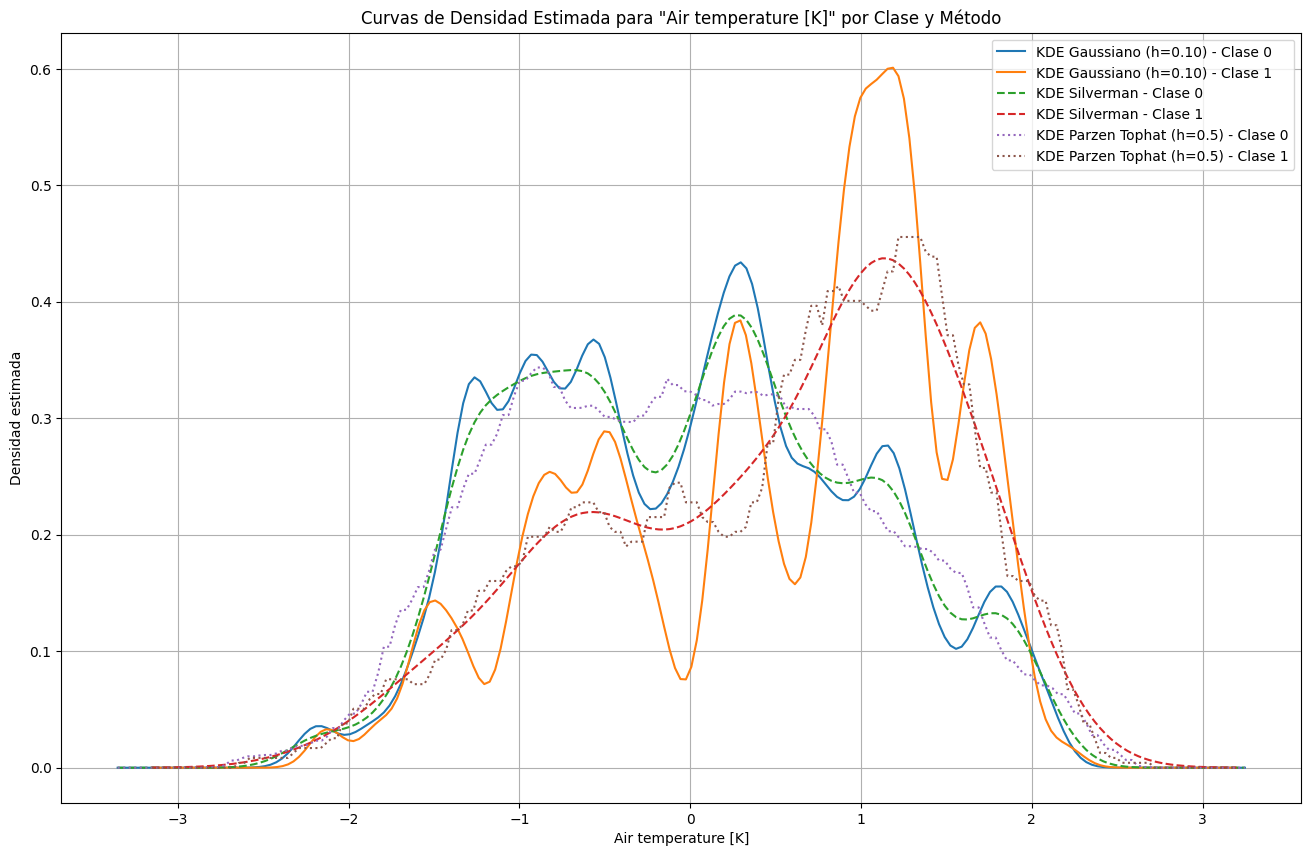

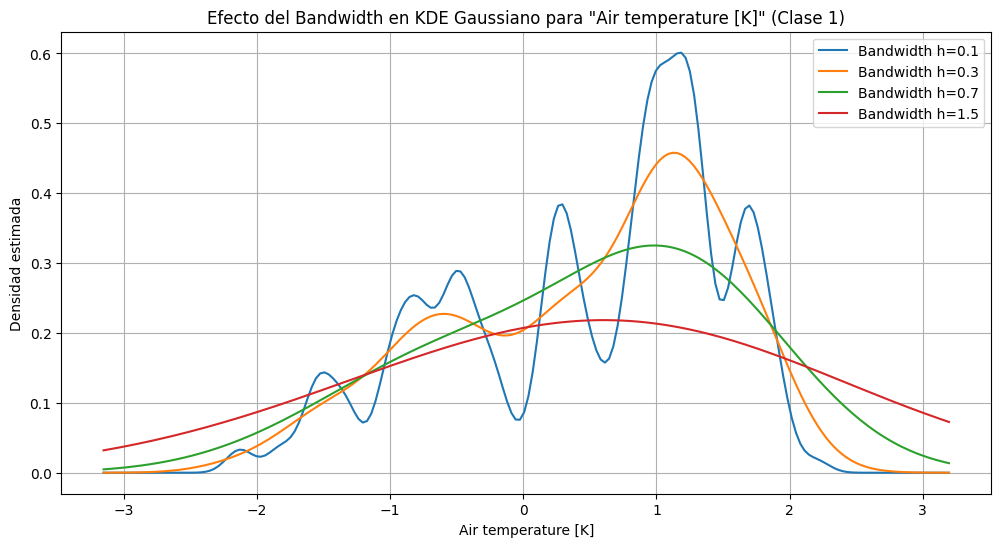

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import seaborn as sns

# Seleccionar una variable numérica para visualizar (por ejemplo, 'Air temperature [K]')
variable = 'Air temperature [K]'
clases = y_train.unique()

# Preparar figura
plt.figure(figsize=(16, 10))

# 1. KDE Gaussiano (bandwidth óptimo encontrado)
for clase in clases:
    datos = X_train[y_train == clase][variable]
    kde = KernelDensity(kernel='gaussian', bandwidth=best_h).fit(datos.values.reshape(-1, 1))
    x_plot = np.linspace(datos.min()-1, datos.max()+1, 200)
    log_dens = kde.score_samples(x_plot.reshape(-1, 1))
    plt.plot(x_plot, np.exp(log_dens), label=f'KDE Gaussiano (h={best_h:.2f}) - Clase {clase}')

# 2. KDE Silverman (scipy)
for clase in clases:
    datos = X_train[y_train == clase][variable]
    kde_silverman = gaussian_kde(datos)
    x_plot = np.linspace(datos.min()-1, datos.max()+1, 200)
    plt.plot(x_plot, kde_silverman(x_plot), '--', label=f'KDE Silverman - Clase {clase}')

# 3. KDE Parzen (Tophat, h fijo)
H_PARZEN_FIJO = 0.5
for clase in clases:
    datos = X_train[y_train == clase][variable]
    kde_parzen = KernelDensity(kernel='tophat', bandwidth=H_PARZEN_FIJO).fit(datos.values.reshape(-1, 1))
    x_plot = np.linspace(datos.min()-1, datos.max()+1, 200)
    log_dens = kde_parzen.score_samples(x_plot.reshape(-1, 1))
    plt.plot(x_plot, np.exp(log_dens), ':', label=f'KDE Parzen Tophat (h={H_PARZEN_FIJO}) - Clase {clase}')

plt.title(f'Curvas de Densidad Estimada para "{variable}" por Clase y Método')
plt.xlabel(variable)
plt.ylabel('Densidad estimada')
plt.legend()
plt.grid(True)
plt.show()

# Visualizar el efecto del bandwidth en KDE Gaussiano para una clase
plt.figure(figsize=(12, 6))
bandwidths = [0.1, 0.3, 0.7, 1.5]
clase = clases[1] if len(clases) > 1 else clases[0]
datos = X_train[y_train == clase][variable]
x_plot = np.linspace(datos.min()-1, datos.max()+1, 200)
for h in bandwidths:
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(datos.values.reshape(-1, 1))
    log_dens = kde.score_samples(x_plot.reshape(-1, 1))
    plt.plot(x_plot, np.exp(log_dens), label=f'Bandwidth h={h}')
plt.title(f'Efecto del Bandwidth en KDE Gaussiano para "{variable}" (Clase {clase})')
plt.xlabel(variable)
plt.ylabel('Densidad estimada')
plt.legend()
plt.grid(True)
plt.show()

## Visualización de curvas de densidad KDE por clase y efecto del parámetro bandwidth

A continuación se grafican las curvas de densidad estimadas para algunas variables numéricas, diferenciando por clase y utilizando diferentes métodos de KDE. También se muestra el efecto del parámetro `bandwidth` sobre la forma de la distribución estimada.

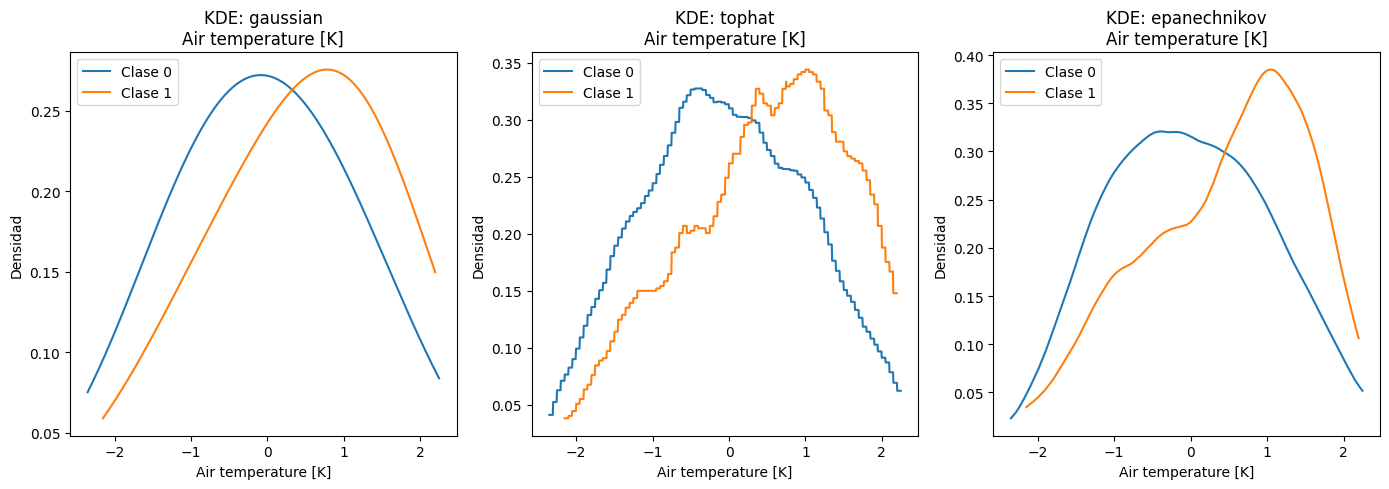

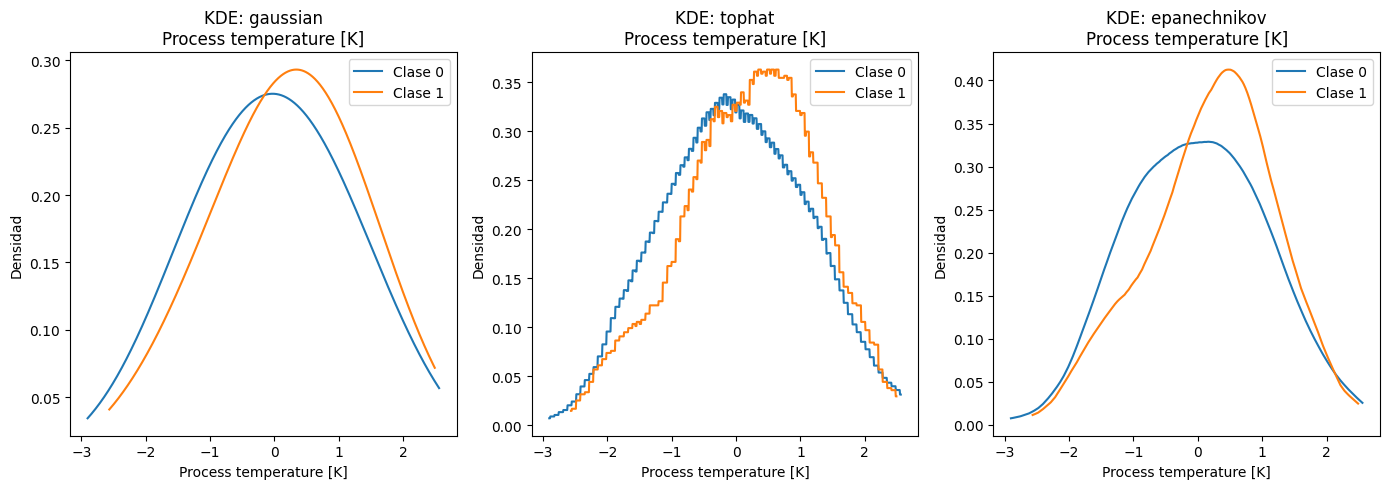

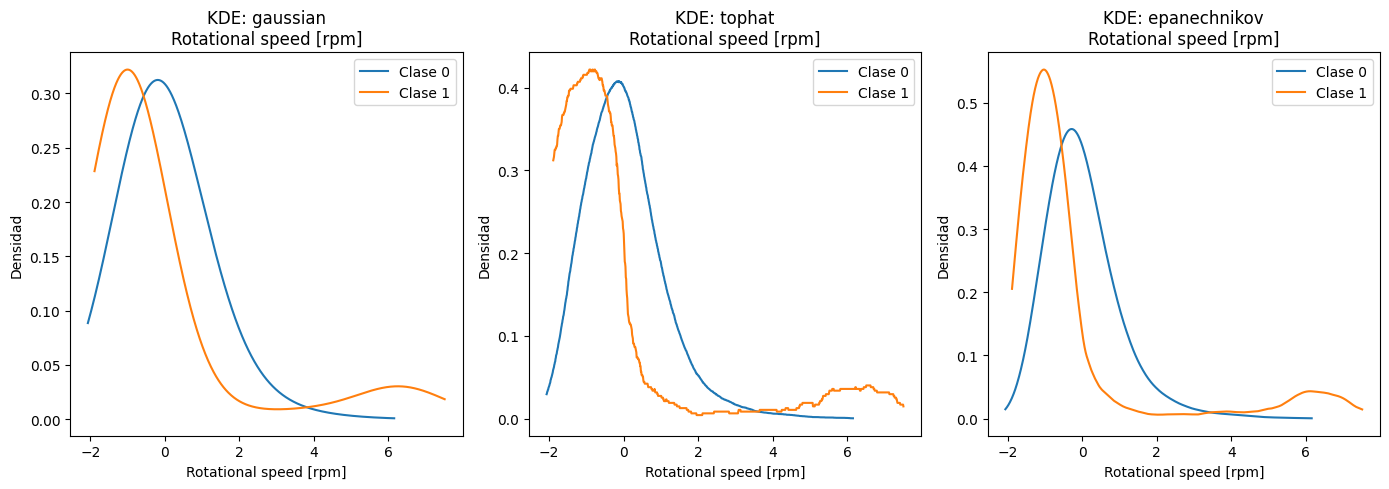

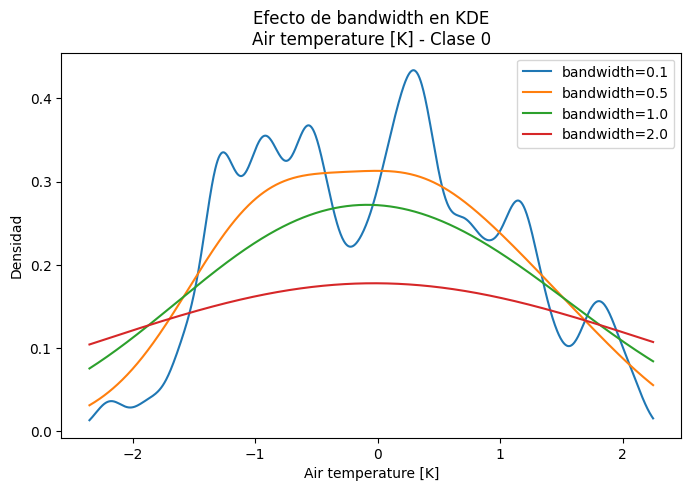

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

# Selecciona algunas variables numéricas para graficar
variables_a_graficar = columnas_numericas[:3]  # Puedes cambiar la cantidad o elegir otras
clases_unicas = np.unique(y)

# Métodos de KDE a comparar
tipos_kde = ['gaussian', 'tophat', 'epanechnikov']

for variable in variables_a_graficar:
    plt.figure(figsize=(14, 5))
    for i, tipo in enumerate(tipos_kde):
        plt.subplot(1, len(tipos_kde), i+1)
        for clase in clases_unicas:
            datos_clase = X_train[variable][y_train == clase].values[:, np.newaxis]
            kde = KernelDensity(kernel=tipo, bandwidth=1.0).fit(datos_clase)
            x_plot = np.linspace(datos_clase.min(), datos_clase.max(), 1000)[:, np.newaxis]
            log_dens = kde.score_samples(x_plot)
            plt.plot(x_plot[:, 0], np.exp(log_dens), label=f'Clase {clase}')
        plt.title(f"KDE: {tipo}\n{variable}")
        plt.xlabel(variable)
        plt.ylabel('Densidad')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Efecto del parámetro bandwidth
def plot_bandwidth_effect(variable, clase, kernel='gaussian'):
    datos_clase = X_train[variable][y_train == clase].values[:, np.newaxis]
    x_plot = np.linspace(datos_clase.min(), datos_clase.max(), 1000)[:, np.newaxis]
    plt.figure(figsize=(8, 5))
    for bw in [0.1, 0.5, 1.0, 2.0]:
        kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(datos_clase)
        log_dens = kde.score_samples(x_plot)
        plt.plot(x_plot[:, 0], np.exp(log_dens), label=f'bandwidth={bw}')
    plt.title(f'Efecto de bandwidth en KDE\n{variable} - Clase {clase}')
    plt.xlabel(variable)
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

# Ejemplo: primer variable y primera clase
plot_bandwidth_effect(variables_a_graficar[0], clases_unicas[0])